# Abstract

Prepare TFRecord dataset for model training/testing

- Write images to TFRecord files
- Create dataset from TFRecord files
- Restore images from loaded dataset

In [5]:
import tensorflow as tf
from prepare_dataset import write_images_to_tfrecord, create_dataset_from_tfrecord

## 1. Write Image to TFRecord File

In [7]:
# Write the raw image files to `images.tfrecords`
train_record_file, test_record_file = write_images_to_tfrecord('samples/qq/*.jpg', 'dataset',
                                                               prefix_record='qq_captcha',
                                                               split_test=0.1,  # split train/test rate
                                                               buffer_size=10000)

## 2. Create Dataset from TFRecord File

In [9]:
# create (image, label) dataset from TFRecord file
train_ds = create_dataset_from_tfrecord(train_record_file, batch_size=128, image_size=(60, 120), label_prefix='A')
test_ds = create_dataset_from_tfrecord(test_record_file, batch_size=128, image_size=(60, 120), label_prefix='A')

In [10]:
train_ds.element_spec

(TensorSpec(shape=(None, 60, 120, 3), dtype=tf.float32, name=None),
 {'A0': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
  'A1': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
  'A2': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
  'A3': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)})

## 3. Show Images in First Batch

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# get images in first batch
batch_images, batch_labels = next(train_ds.take(1).as_numpy_iterator())

# check shape
print(batch_images.shape) # (batch_size, height, width, channels)

for k,v in batch_labels.items(): # batch_labels is a dict with batch size for each value
    print(k, ' -> ', v.shape) # batch_size

(128, 60, 120, 3)
A0  ->  (128, 1)
A1  ->  (128, 1)
A2  ->  (128, 1)
A3  ->  (128, 1)


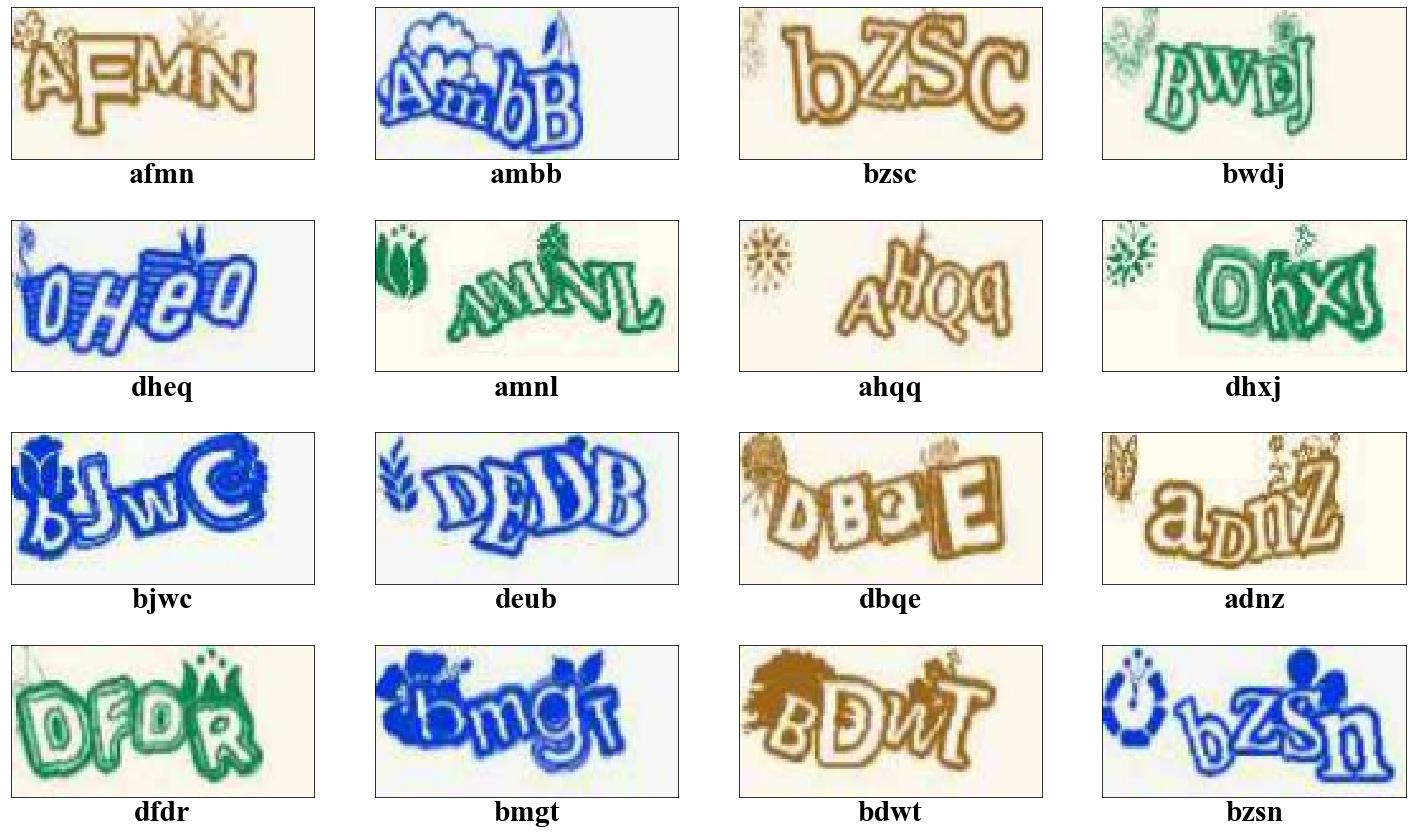

In [12]:
plt.figure(figsize=(25,15)) # width, height
for i,(image,*labels) in enumerate(zip(batch_images, *batch_labels.values()), start=1):
    if i > 16:  break
    plt.subplot(4, 4, i)
    
    # imshow get image shape: either (h, w, c=3) for RGB images
    # or (h, w) for gray image
    if image.shape[-1]==1:
        image = tf.reshape(image, shape=(60, 120))

    plt.imshow(image, cmap=plt.cm.binary)    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(''.join([chr(ord('a') + c) for c in labels]), 
               fontdict={'family': 'Times New Roman', 'size' : 30})
plt.show()